In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, cross_validate


In [2]:
data = pd.read_csv('patients_data_with_RVoutcomes.csv') #load
data = data.dropna(subset=['Birthday']) #preprocess data - drop nulls 
data['RV Dysfunction'] = data['RV Dysfunction'].replace('0', pd.NA) # Convert '0' to NaN
data = data.dropna(subset=['RV Dysfunction'])


In [3]:
X = data.select_dtypes(exclude=['object', 'string'])
Y = data['RV Dysfunction']
feature_names = X.columns


In [4]:
imputer = SimpleImputer(strategy='mean') #impute based on mean
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=feature_names)

Y_grouped = Y.replace({
 'Moderate': 'High Dysfunction',
 'Severe': 'High Dysfunction',
 'Normal': 'Low Dysfunction',
 'Mild': 'Low Dysfunction'
})
print(pd.unique(Y_grouped))

label_encoder = LabelEncoder()

Y_encoded = label_encoder.fit_transform(Y_grouped)


['High Dysfunction' 'Low Dysfunction']


In [5]:
#Standardize features to mean=0, variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #scaling each feature down to 0-1 



Cross-Validation Scores: [0.65934066 0.57777778 0.64444444 0.6        0.63333333]
Mean CV Accuracy: 0.6230 (+/- 0.0597)


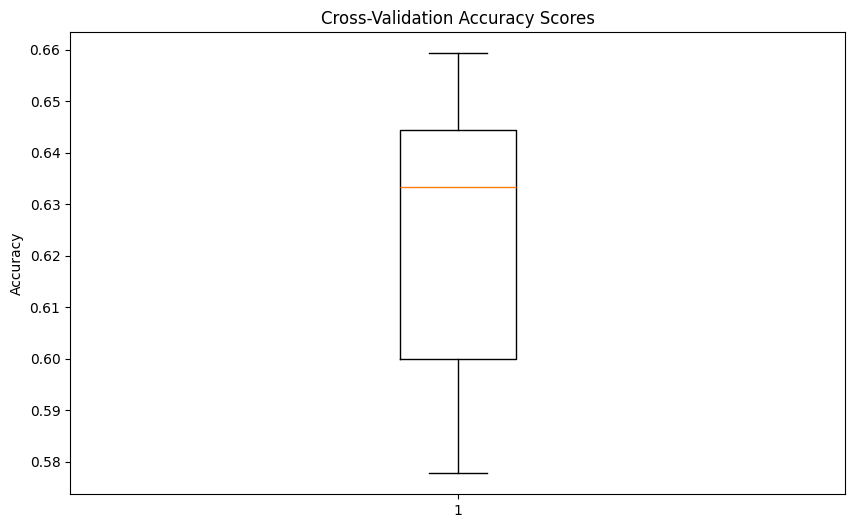

In [6]:
# Perform Cross-Validation
def perform_cross_validation(X, y, model, cv=5):
    # Use StratifiedKFold to maintain class distribution
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Compute cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')
    
    # Print cross-validation results
    print(f"\nCross-Validation Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return cv_scores

# Initialize the model
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=500, random_state=42)

# Perform cross-validation
cv_scores = perform_cross_validation(X_scaled, Y_encoded, log_reg)

# Visualize Cross-Validation Scores
plt.figure(figsize=(10, 6))
plt.boxplot(cv_scores)
plt.title('Cross-Validation Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()


[1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1
 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1]


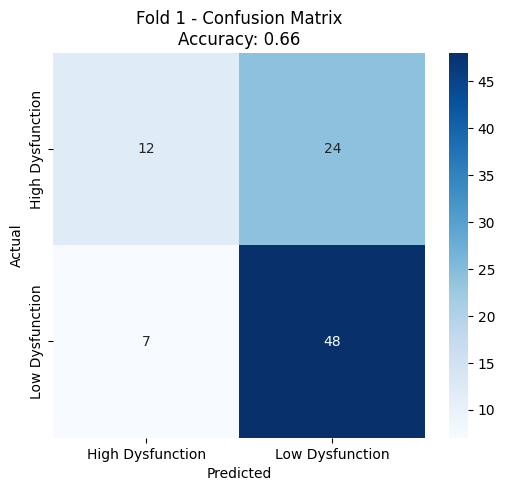

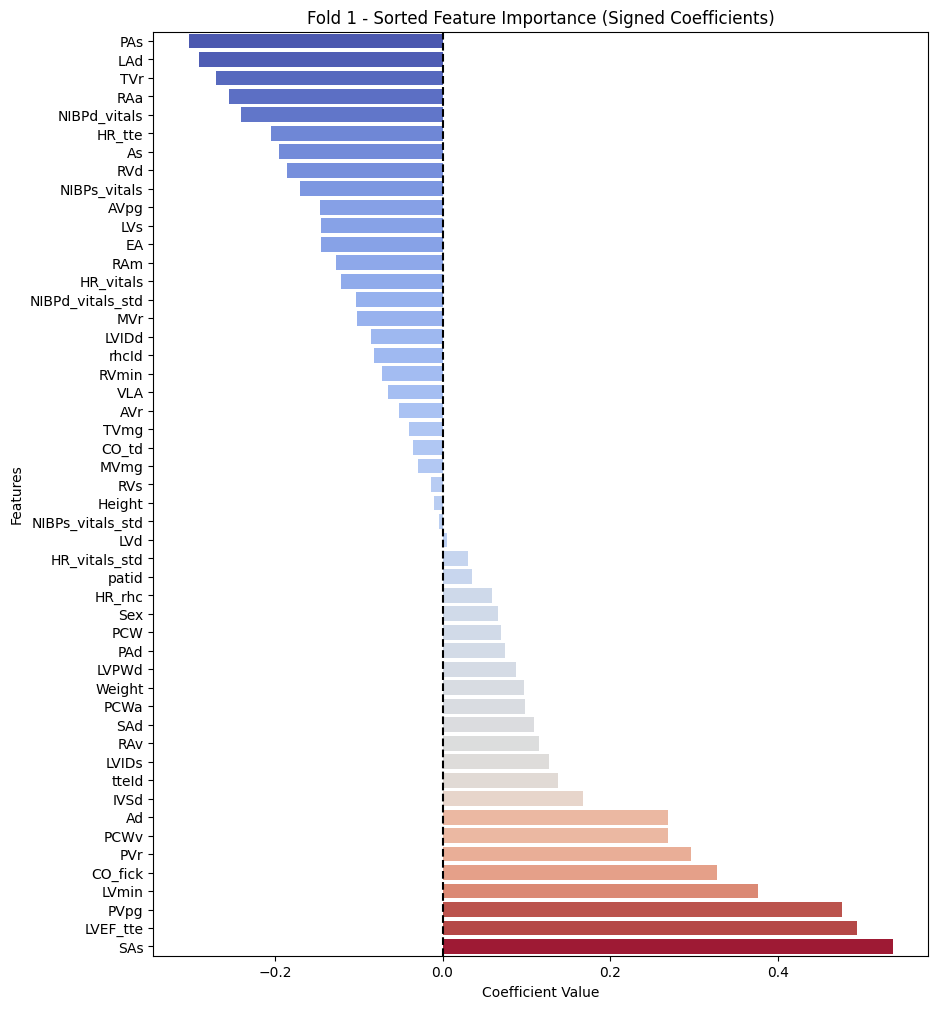

[1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1
 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1
 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1]


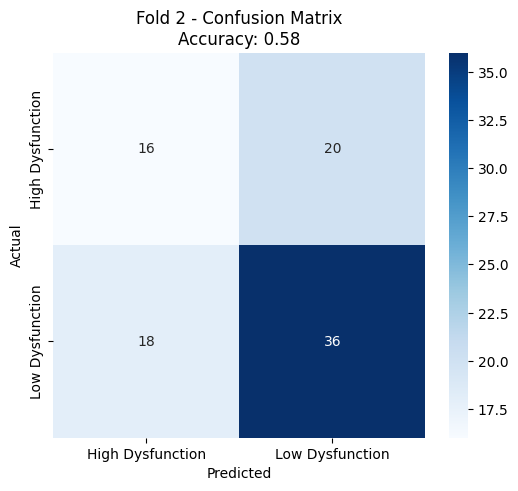

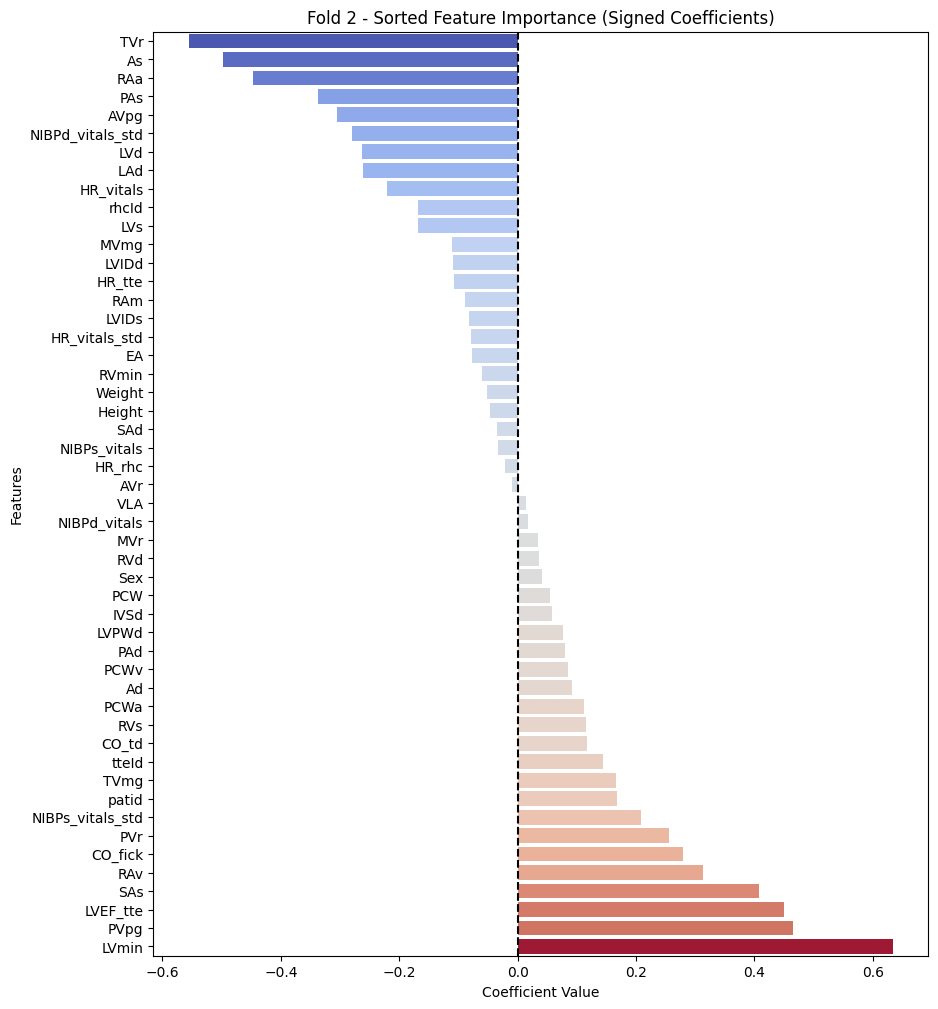

[0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1
 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1]


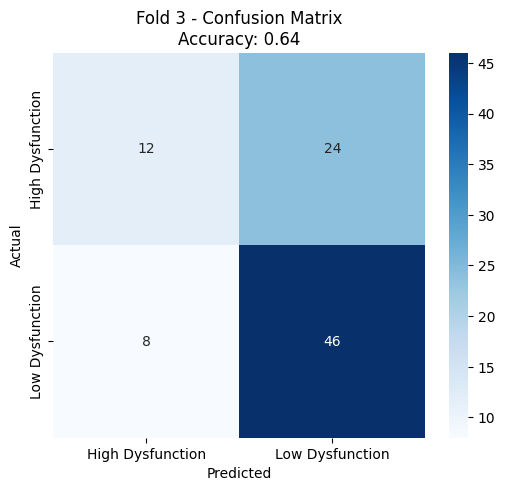

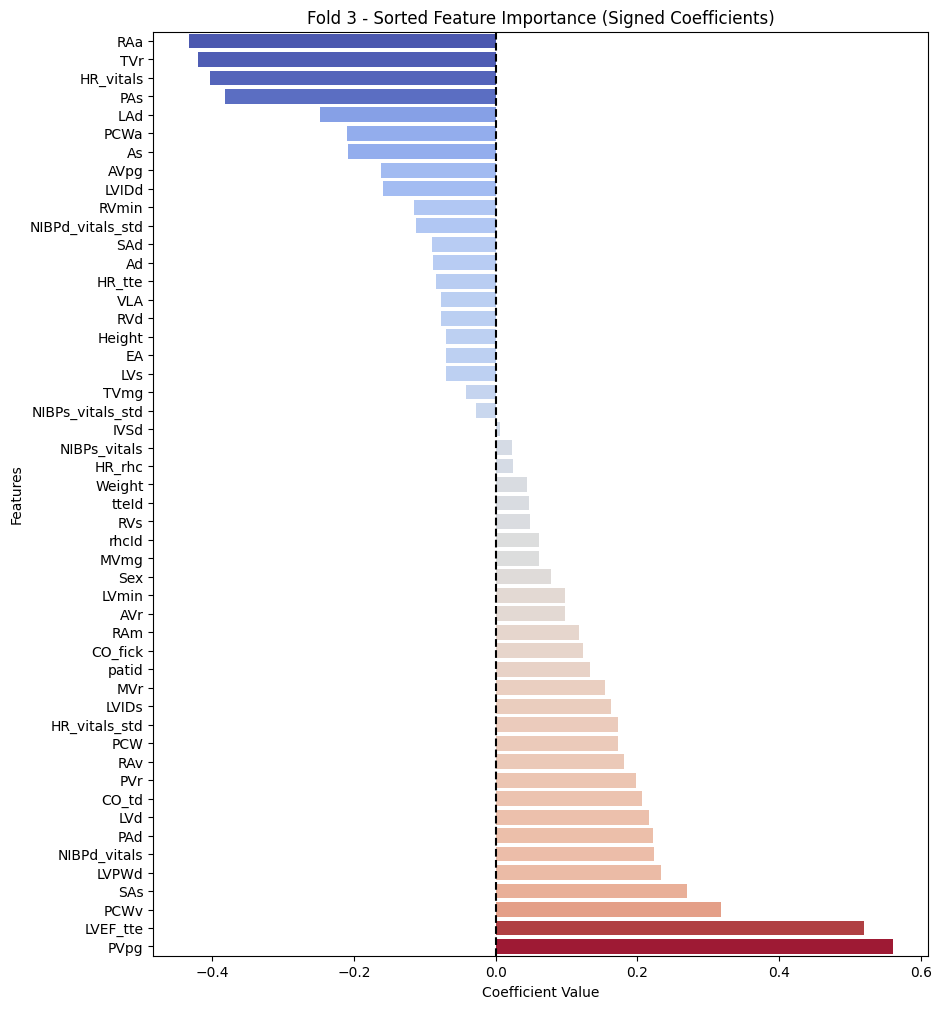

[0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0
 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0
 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0]


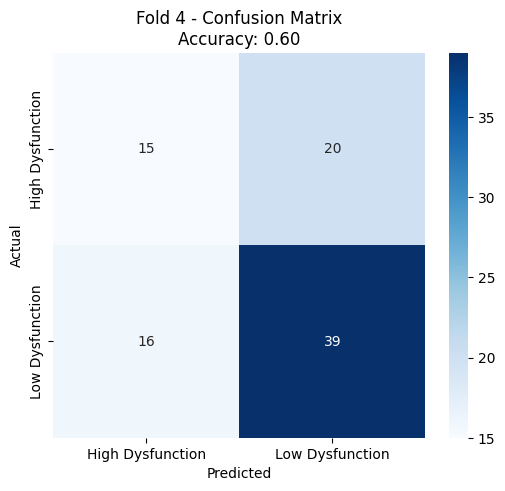

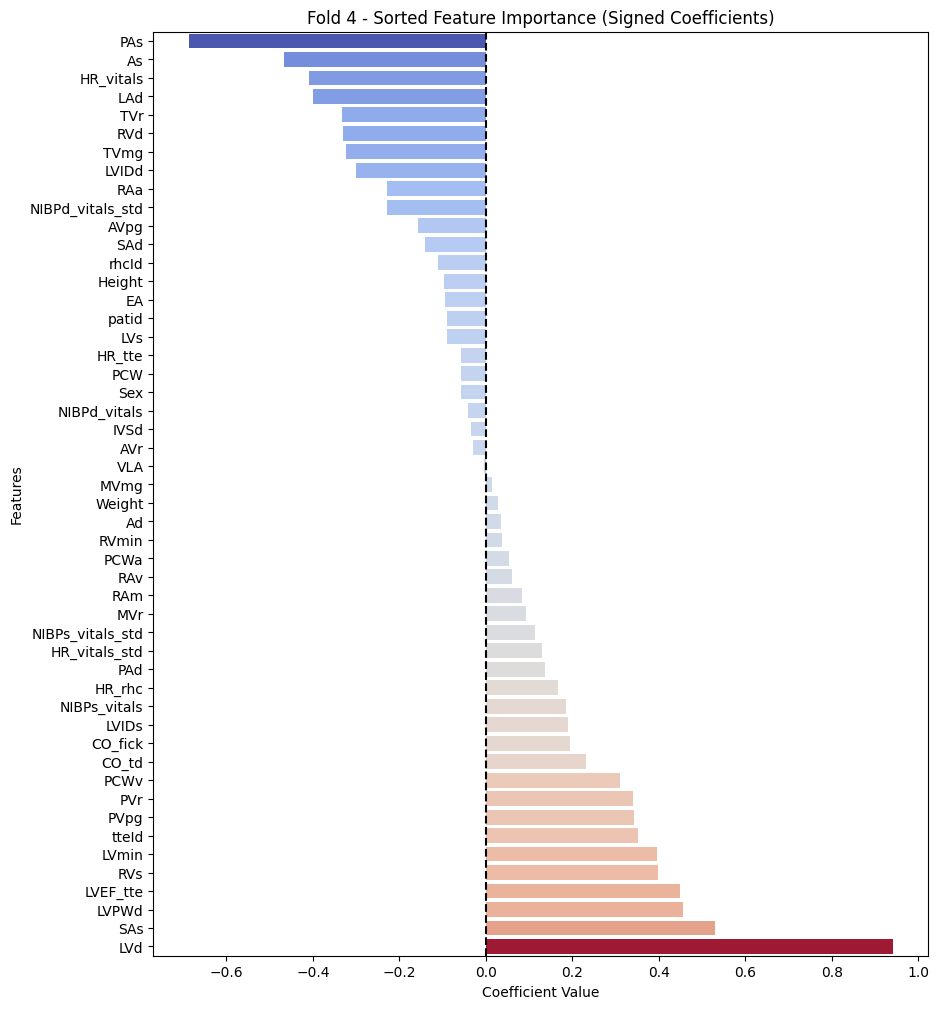

[1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0
 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0
 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1]


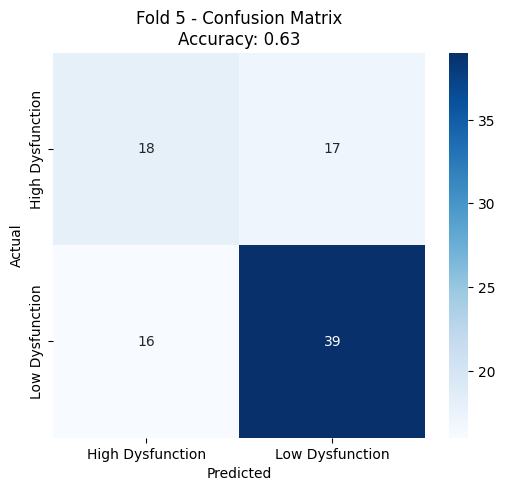

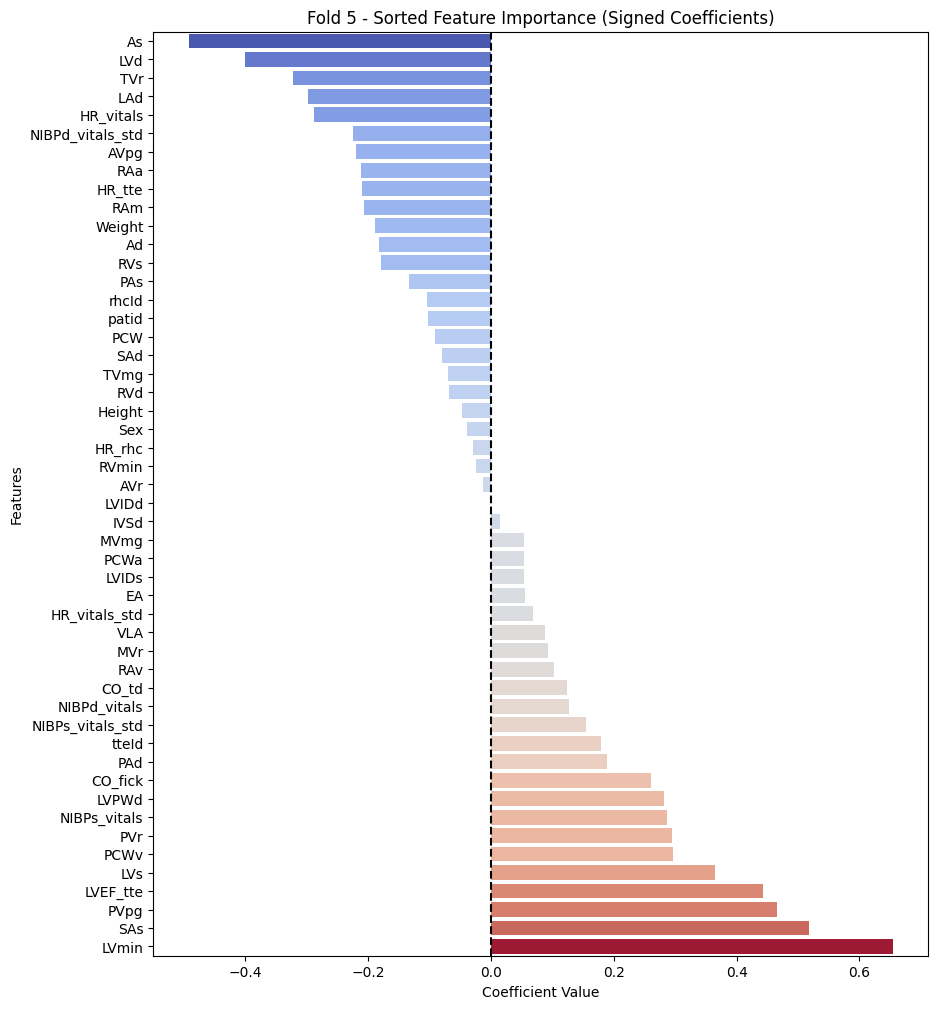

'Blue for negative & Red for positive impact.\nFeatures with positive coefficients (red) increase the probability of the target outcome.\nFeatures with negative coefficients (blue) decrease the probability of the target outcome.\nFeatures near 0 have low impact on predictions.'

In [22]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

coefs = []
feature_names = X.columns  # Assuming X is a DataFrame
#print(feature_names)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, Y_encoded)):
    # Train model
    log_reg.fit(X_scaled[train_idx], Y_encoded[train_idx])
    
    # Store coefficients
    coefs.append(log_reg.coef_[0])  # Store raw coefficients
    
    # Confusion matrix plot
    y_pred = log_reg.predict(X_scaled[val_idx])
    cm = confusion_matrix(Y_encoded[val_idx], y_pred)
    print(y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Fold {fold+1} - Confusion Matrix\nAccuracy: {accuracy_score(Y_encoded[val_idx], y_pred):.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Sort by actual coefficient values
    coef_values = log_reg.coef_[0]
    sorted_indices = np.argsort(coef_values)  # Sort by raw values (not absolute)
    sorted_features = np.array(feature_names)[sorted_indices]
    sorted_coef_values = coef_values[sorted_indices]

    # Feature importance plot
    plt.figure(figsize=(10, 12))
    sns.barplot(x=sorted_coef_values, y=sorted_features, hue=sorted_coef_values, palette="coolwarm", legend=False)
    plt.axvline(x=0, color='black', linestyle='--')  # Add vertical line at 0 for reference
    plt.title(f'Fold {fold+1} - Sorted Feature Importance (Signed Coefficients)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.show()
    
'''Blue for negative & Red for positive impact.
Features with positive coefficients (red) increase the probability of the target outcome.
Features with negative coefficients (blue) decrease the probability of the target outcome.
Features near 0 have low impact on predictions.'''


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

#Pipeline object that chains multiple transformations together.
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale data
    ('model', LogisticRegression(multi_class='ovr', max_iter=500, class_weight='balanced'))  # Step 2: Train model
])


In [8]:
def plot_feature_importance(results, feature_names, class_name):
    coefs = [estimator.named_steps['logisticregression'].coef_[0] for estimator in results['estimator']]
    avg_coefs = np.mean(coefs, axis=0)
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': avg_coefs
    }).sort_values('Importance', ascending=True)  # Changed to ascending=True
    
    # Color code based on coefficient sign
    colors = ['red' if x < 0 else 'blue' for x in importance_df['Importance']]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette=colors)
    plt.title(f'Feature Importance (Target: {class_name})')
    plt.xlabel('Impact on probability')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.show()

# Plot for High Dysfunction
plot_feature_importance(results, feature_names, "High Dysfunction")
#plot_feature_importance(results, feature_names, "Low Dysfunction")

NameError: name 'results' is not defined

In [25]:
data = pd.read_csv('patients_data_with_RVoutcomes.csv')
#print(data.columns.tolist())
# List of features to use, including the target variable
selected_features = [
    'patKey', 'patid', 'rhcId', 'RHCDate', 'Sex', 'Height', 'Weight', 'Birthday',
    'CO_td', 'CO_fick', 'PCW', 'PCWa', 'PCWv', 'PAs', 'PAd', 'RVs', 'RVmin', 'RVd',
    'RAa', 'RAv', 'RAm', 'LVs', 'LVd', 'LVmin', 'SAs', 'SAd', 'HR_rhc', 'HR_vitals',
    'HR_vitals_std', 'NIBPs_vitals', 'NIBPs_vitals_std', 'NIBPd_vitals',
    'NIBPd_vitals_std', 'As', 'Ad', 'tteId', 'TTEDate', 'LVIDd', 'LVIDs', 'HR_tte',
    'LVEF_tte', 'EA', 'IVSd', 'LVPWd', 'LAd', 'VLA', 'AVr', 'AVpg', 'MVr', 'MVmg',
    'TVr', 'TVmg', 'PVr', 'PVpg', 'AVr_str', 'MVr_str', 'TVr_str', 'PVr_str', 'patkey',
    'RV Dysfunction'
]

# Drop any rows with NaN values in any of the selected features
data = data[selected_features].dropna()

#Convert date/time object to number of days
data['RHCDate'] = pd.to_datetime(data['RHCDate']).apply(lambda x: x.toordinal())
data['TTEDate'] = pd.to_datetime(data['TTEDate']).apply(lambda x: x.toordinal())
data['Birthday'] = pd.to_datetime(data['Birthday']).apply(lambda x: x.toordinal())


In [26]:
feature_names = X.columns
print(feature_names)

Index(['patid', 'rhcId', 'Sex', 'Height', 'Weight', 'CO_td', 'CO_fick', 'PCW',
       'PCWa', 'PCWv', 'PAs', 'PAd', 'RVs', 'RVmin', 'RVd', 'RAa', 'RAv',
       'RAm', 'LVs', 'LVd', 'LVmin', 'SAs', 'SAd', 'HR_rhc', 'HR_vitals',
       'HR_vitals_std', 'NIBPs_vitals', 'NIBPs_vitals_std', 'NIBPd_vitals',
       'NIBPd_vitals_std', 'As', 'Ad', 'tteId', 'LVIDd', 'LVIDs', 'HR_tte',
       'LVEF_tte', 'EA', 'IVSd', 'LVPWd', 'LAd', 'VLA', 'AVr', 'AVpg', 'MVr',
       'MVmg', 'TVr', 'TVmg', 'PVr', 'PVpg'],
      dtype='object')


In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
def train_and_evaluate(model, model_name, X_train, Y_train, X_test, Y_test):
    """
    Trains and evaluates a classification model.
    Prints classification report, confusion matrix, and calculates ROC AUC.
    """

    print(f"\n--- {model_name} ---")

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions
    Y_pred = model.predict(X_test)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred, target_names=label_encoder.classes_))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(Y_test, Y_pred)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Calculate ROC AUC
    Y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
    roc_auc = roc_auc_score(Y_test, Y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
#True Positive Rate (TPR) = recall

The higher the AUC, the better the model is at distinguishing between the positive and negative classes.

We are using 5-fold cross-validation. This means the training data is split into 5 parts. GridSearchCV trains and tests the model 5 times, each time using a different part as the test set.
Performance Evaluation: GridSearchCV keeps track of how well each hyperparameter combination performs during cross-validation.

Regularization: Regularization is a technique used to prevent overfitting in machine learning models. Overfitting happens when a model learns the training data too well, including its noise and specific details, and performs poorly on new, unseen data. Regularization adds a penalty to the model's complexity to discourage it from overfitting.



--- Random Forest ---

Classification Report:
                  precision    recall  f1-score   support

High Dysfunction       0.48      0.28      0.35        54
 Low Dysfunction       0.63      0.80      0.71        82

        accuracy                           0.60       136
       macro avg       0.56      0.54      0.53       136
    weighted avg       0.57      0.60      0.57       136


Confusion Matrix:


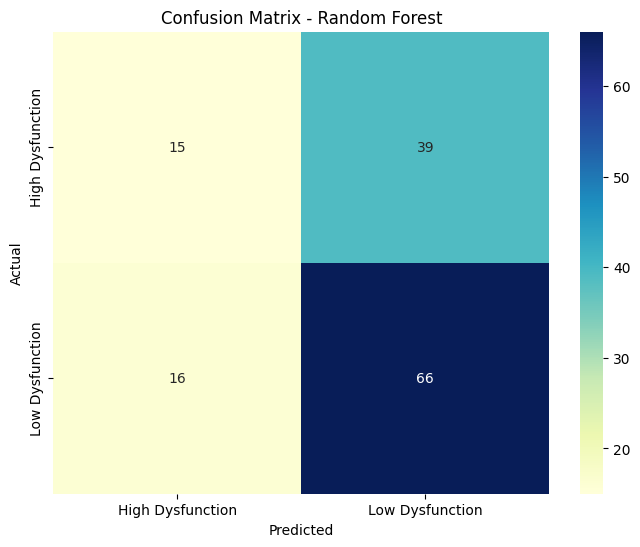

ROC AUC: 0.6070


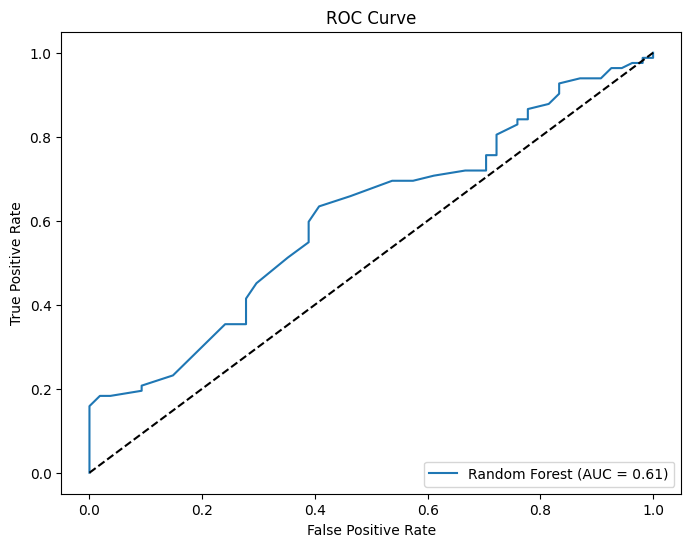

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.3, stratify=Y_encoded, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate(rf_model, "Random Forest", X_train, Y_train, X_test, Y_test) 


--- Support Vector Machine ---

Classification Report:
                  precision    recall  f1-score   support

High Dysfunction       0.52      0.24      0.33        54
 Low Dysfunction       0.63      0.85      0.73        82

        accuracy                           0.61       136
       macro avg       0.58      0.55      0.53       136
    weighted avg       0.59      0.61      0.57       136


Confusion Matrix:


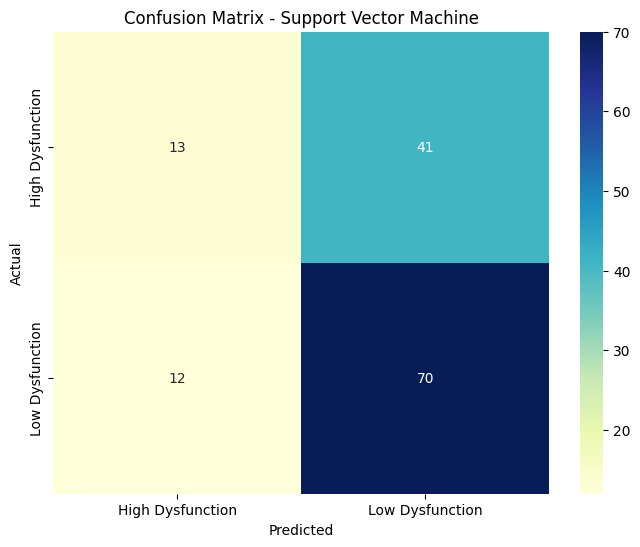

ROC AUC: 0.6183


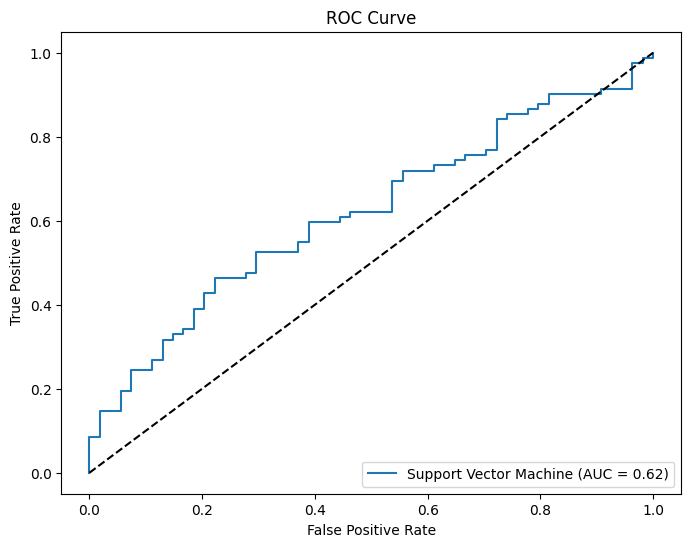

In [ ]:
svm_model = SVC(probability=True, random_state=42)  # probability=True for ROC AUC
train_and_evaluate(svm_model, "Support Vector Machine", X_train, Y_train, X_test, Y_test)

In [12]:
'''import shap
def shap_analysis(pipeline, X_sample, feature_names, class_index=0):
    # Apply preprocessing steps using the pipeline components
    imputer = pipeline.named_steps['imputer']
    scaler = pipeline.named_steps['scaler']
    
    # Apply preprocessing steps manually
    X_imputed = imputer.transform(X_sample)
    preprocessed_sample = scaler.transform(X_imputed)
    
    # Create explainer with the actual model and preprocessed features
    explainer = shap.LinearExplainer(
        pipeline.named_steps['model'], 
        preprocessed_sample,
        feature_names=feature_names
    )
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(preprocessed_sample)
    
    # Verify dimensions
    print(f"SHAP values shape: {np.array(shap_values).shape}")
    print(f"Features shape: {preprocessed_sample[0].shape}")

    # Individual prediction explanation (first sample)
    plt.figure()
    shap.force_plot(
        explainer.expected_value[class_index],
        shap_values[class_index][0],  # First sample values
        features=preprocessed_sample[0],
        feature_names=feature_names,
        matplotlib=True,
        contribution_threshold=0.05
    )
    plt.tight_layout()
    plt.show()

# Use last fold's estimator for SHAP analysis
shap_model = results['estimator'][-1]
X_sample = X_scaled[:1]  # First sample

shap_analysis(shap_model, X_sample, feature_names)
'''

'import shap\ndef shap_analysis(pipeline, X_sample, feature_names, class_index=0):\n    # Apply preprocessing steps using the pipeline components\n    imputer = pipeline.named_steps[\'imputer\']\n    scaler = pipeline.named_steps[\'scaler\']\n    \n    # Apply preprocessing steps manually\n    X_imputed = imputer.transform(X_sample)\n    preprocessed_sample = scaler.transform(X_imputed)\n    \n    # Create explainer with the actual model and preprocessed features\n    explainer = shap.LinearExplainer(\n        pipeline.named_steps[\'model\'], \n        preprocessed_sample,\n        feature_names=feature_names\n    )\n    \n    # Calculate SHAP values\n    shap_values = explainer.shap_values(preprocessed_sample)\n    \n    # Verify dimensions\n    print(f"SHAP values shape: {np.array(shap_values).shape}")\n    print(f"Features shape: {preprocessed_sample[0].shape}")\n\n    # Individual prediction explanation (first sample)\n    plt.figure()\n    shap.force_plot(\n        explainer.expec

In [13]:
'''# Import additional models and metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define models with default parameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'SVM': SVC(class_weight='balanced', probability=True),
}

# Feature selection based on clinical relevance (modify as needed)
selected_features = ['Height', 'Weight', 'PCW', 'RAa', 'LVEF_tte', 'CO_fick', 'HR_vitals']
X_selected = X[selected_features]

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1': 'f1',
    'AUC': 'roc_auc'
}

# Evaluate models
results = {}
for name, model in models.items():
    # Create full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, X_selected, y_encoded, cv=cv, 
                               scoring=metrics, n_jobs=-1)
    
    # Store results
    results[name] = {
        'fit_time': cv_results['fit_time'],
        'score_time': cv_results['score_time'],
        'test_accuracy': cv_results['test_Accuracy'],
        'test_precision': cv_results['test_Precision'],
        'test_recall': cv_results['test_Recall'],
        'test_f1': cv_results['test_F1'],
        'test_auc': cv_results['test_AUC']
    }

# Visualize results
plt.figure(figsize=(15, 8))
metrics_to_plot = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_auc']
positions = np.arange(len(metrics_to_plot))

for i, metric in enumerate(metrics_to_plot):
    ax = plt.subplot(2, 3, i+1)
    for j, (model, scores) in enumerate(results.items()):
        plt.bar(j + i*0.15, np.mean(scores[metric]), 0.15, label=model)
    
    plt.title(metric.replace('test_', '').capitalize())
    plt.xticks([])
    plt.ylim(0.5, 0.85)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()'''


"# Import additional models and metrics\nfrom sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score\n\n# Define models with default parameters\nmodels = {\n    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),\n    'Random Forest': RandomForestClassifier(class_weight='balanced'),\n    'SVM': SVC(class_weight='balanced', probability=True),\n}\n\n# Feature selection based on clinical relevance (modify as needed)\nselected_features = ['Height', 'Weight', 'PCW', 'RAa', 'LVEF_tte', 'CO_fick', 'HR_vitals']\nX_selected = X[selected_features]\n\n# Create preprocessing pipeline\npreprocessor = Pipeline([\n    ('imputer', SimpleImputer(strategy='median')),\n    ('scaler', StandardScaler())\n])\n\n# Cross-validation setup\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\nmetrics = {\n    'Accuracy': '